In [ ]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
import pandas as pd
from keras import optimizers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from sklearn import preprocessing
import numpy as np
import re
# try using stacking
from mlxtend.classifier import StackingClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [7]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED", female="#F08080")

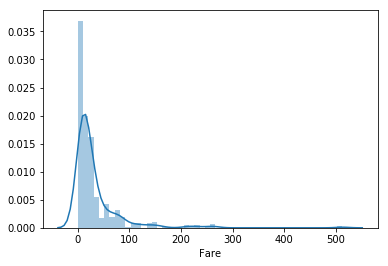

In [15]:
sns.distplot(train_df['Fare'])

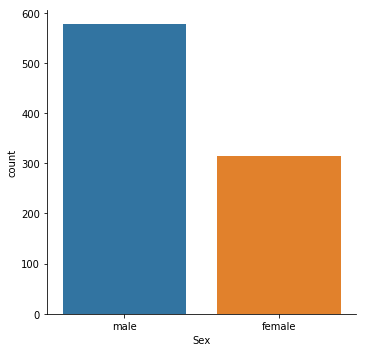

In [4]:
sns.catplot('Sex', data=train_df, kind='count')

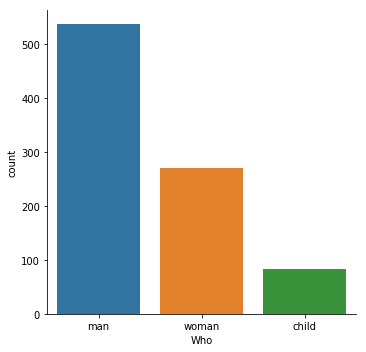

In [5]:
sns.catplot('Who', data=train_df, kind='count')

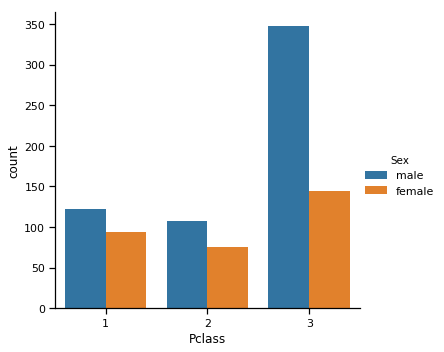

In [20]:
sns.catplot('Pclass', data=train_df, hue='Sex', kind='count')

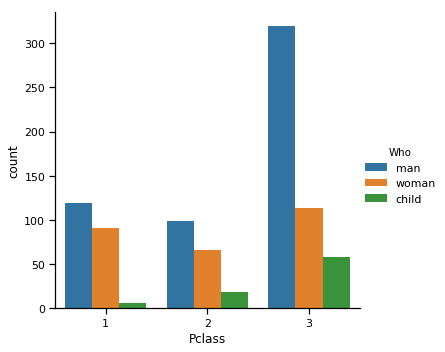

In [22]:
sns.catplot('Pclass', data=train_df, hue='Who', kind='count')

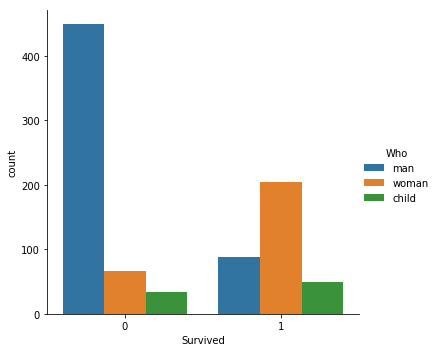

In [8]:
sns.catplot('Survived', data=train_df, hue='Who', kind='count')

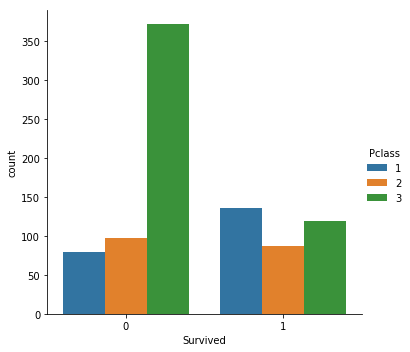

In [9]:
sns.catplot('Survived', data=train_df, hue='Pclass', kind='count')

In [49]:
? re.sub

In [18]:
random_state = 42
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
y = train_df['Survived']
# train_df.drop(['Survived'], axis=1, inplace=True)
test_ids = test_df['PassengerId']
def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]
    
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset.loc[dataset.Title=='Ms', 'Title'] = 'Miss' # unify the naming
    dataset['Title'] = dataset['Title'].replace(['Mme', 'Mlle'], 'Mrs') # seem to be the title for old lady
    dataset.loc[((dataset.Title=='Master') | (dataset.Title.isnull())) & (dataset.Age<15) & (dataset.Sex=='male'), 'Title'] = 'Boy'
    dataset.loc[((dataset.Title=='Mrs') | dataset.Title.isnull() | (dataset.Title=='Miss') ) & (dataset.Sex=='female') & (dataset.Age<15), 'Title'] = 'Girl'
    dataset['Title'] = dataset['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Countess', 'Lady', 'Dona'], 'Royalty')
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
    
combined = pd.concat([train_df, test_df])
grouped_median_age = combined[train_df.Age.notnull()].groupby(['Sex', 'Pclass', 'Title']).median()
grouped_median_age = grouped_median_age.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

def assign_age(row):
    condition = (
        (grouped_median_age['Sex'] == row['Sex']) & 
        (grouped_median_age['Title'] == row['Title']) & 
        (grouped_median_age['Pclass'] == row['Pclass'])
    )
    return grouped_median_age[condition]['Age'].values[0]

for dataset in combine:
    dataset['Age'] = dataset.apply(lambda row: assign_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    dataset.loc[(dataset.Sex=='male') & (dataset.Pclass==3) & (dataset.Title=='Master'), 'Age'] = 35
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset.loc[dataset.Embarked.isnull(), 'Embarked'] = 'S'
    dataset.loc[dataset.Cabin.notnull(), 'Cabin'] = dataset.loc[dataset.Cabin.notnull(), 'Cabin'].map(lambda x: x[0])
    dataset.loc[dataset.Cabin.isnull(), 'Cabin'] = 'U' #unknown
    
def cleanTicket(ticket):
    original_ticket = ticket
    ticket = ticket.split()
    ticket = [''.join(ticket[:-1]), ticket[-1]]
    ticket = ' '.join(ticket)
    ticket = re.sub('/.+ ',' ', ticket)
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = list(map(lambda t : t.strip().upper(), ticket))
    if len(ticket)>2:
        number = ticket[-1]
        non_number = "".join(ticket[:-1])
        ticket = [non_number, number]
#     ticket = list(filter(lambda t : not t.isdigit(), ticket))
    
    if len(ticket) ==2:
        res =  [ticket[0], int(ticket[1])]
    elif len(ticket)==1:
        try:
            res =  ['XXX', int(ticket[0])]
        except:
            res = [ticket[0], 0]
    if ticket[0] in ('AS', 'A4', 'A5', 'A2', 'AQ'):
        res = ['A', ticket[1]]
    elif ticket[0] in ('WE', 'WEP'):
        res = ['W', ticket[1]]
            
#     print(original_ticket, res)
    return res
max_age = combined.Age.max()
max_fare = combined.Fare.max()
age_bands = np.linspace(0, max_age, 6, dtype=int)
fare_bands = np.linspace(0, max_fare, 50)
age_bins = zip(age_bands[:-1], age_bands[1:])
fare_bins = zip(fare_bands[:-1], fare_bands[1:])

for dataset in combine:    
#     print(dataset.loc[dataset.Ticket.notnull(), 'Ticket'].size)
    for i, (age_bin_left, age_bin_right) in enumerate(age_bins):
        print(i, age_bin_left, age_bin_right)
        dataset.loc[(dataset['Age']>=age_bin_left) & (dataset['Age']<age_bin_right), 'AgeBand'] = i+1
#     print(dataset.AgeBand)
#     dataset.loc[dataset['Fare'].isnull(), 'Fare'] = 8
#     for i, (fare_bin_left, fare_bin_right) in enumerate(fare_bins):
#         dataset.loc[(dataset['Fare']>=fare_bin_left) & (dataset['Fare']<fare_bin_right), 'FareBand'] = i+1
#     dataset.loc[ dataset['Age'] <= 15, 'AgeBand'] = 1
#     dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 25), 'AgeBand'] = 2
#     dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35), 'AgeBand'] = 3
#     dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 45), 'AgeBand'] = 4
#     dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 55), 'AgeBand'] = 5
#     dataset.loc[(dataset['Age'] > 55) & (dataset['Age'] <= 65), 'AgeBand'] = 6
#     dataset.loc[(dataset['Age'] > 65), 'AgeBand'] = 7
    dataset['AgeBand'] = dataset['AgeBand'].astype(str)
    dataset.loc[dataset['Fare'].isnull(), 'Fare'] = 8
    dataset.loc[dataset['Fare'] <= 8, 'FareBand'] = 1
    dataset.loc[(dataset['Fare'] > 8) & (dataset['Fare'] <= 50), 'FareBand'] = 2
    dataset.loc[(dataset['Fare'] > 50) & (dataset['Fare'] <= 100), 'FareBand'] = 3
    dataset.loc[ dataset['Fare'] > 100, 'FareBand'] = 4
    dataset['FareBand'] = dataset['FareBand'].astype(str)
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset[['Ticket_NonNumber', 'Ticket_Number']] = pd.DataFrame(dataset['Ticket'].map(cleanTicket).values.tolist(), index=dataset.index)

sns.distplot(train_df['Fare'])
sns.distplot(test_df['Fare'])
test_infos = test_df[['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Ticket', 'Title', 'Ticket_Number', 'FareBand', 'AgeBand', 'Pclass', 'IsAlone']]
for dataset in combine:
    dataset.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Ticket', 'Ticket_Number'], axis=1, inplace=True)
print('columns before', train_df.columns)
train_df.drop(['Survived'], axis=1, inplace=True)
train_df = pd.get_dummies(train_df)
print('columns after', train_df.columns)
print("\tnumber of columns", len(train_df.columns))
test_df = pd.get_dummies(test_df)
# Get missing columns in the training test
missing_cols = set( train_df.columns ) - set( test_df.columns )
print("\tmissing columns", missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_df = test_df[train_df.columns]
train_df.to_csv('train_temp.csv')
# print(train_df.head())

/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0 0 16
1 16 32
2 32 48
3 48 64
4 64 80


KeyError: 'AgeBand'

** before reduced = [0.78212291 0.79888268 0.81460674 0.74719101 0.81355932]
reduced shape (891, 13) (418, 13)
*** retrain after reducing***
0.7912158258762099
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.7811283618230739
**********
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.7800298745969111
**********
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8104177372262514
**********
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.818295672687334
**********


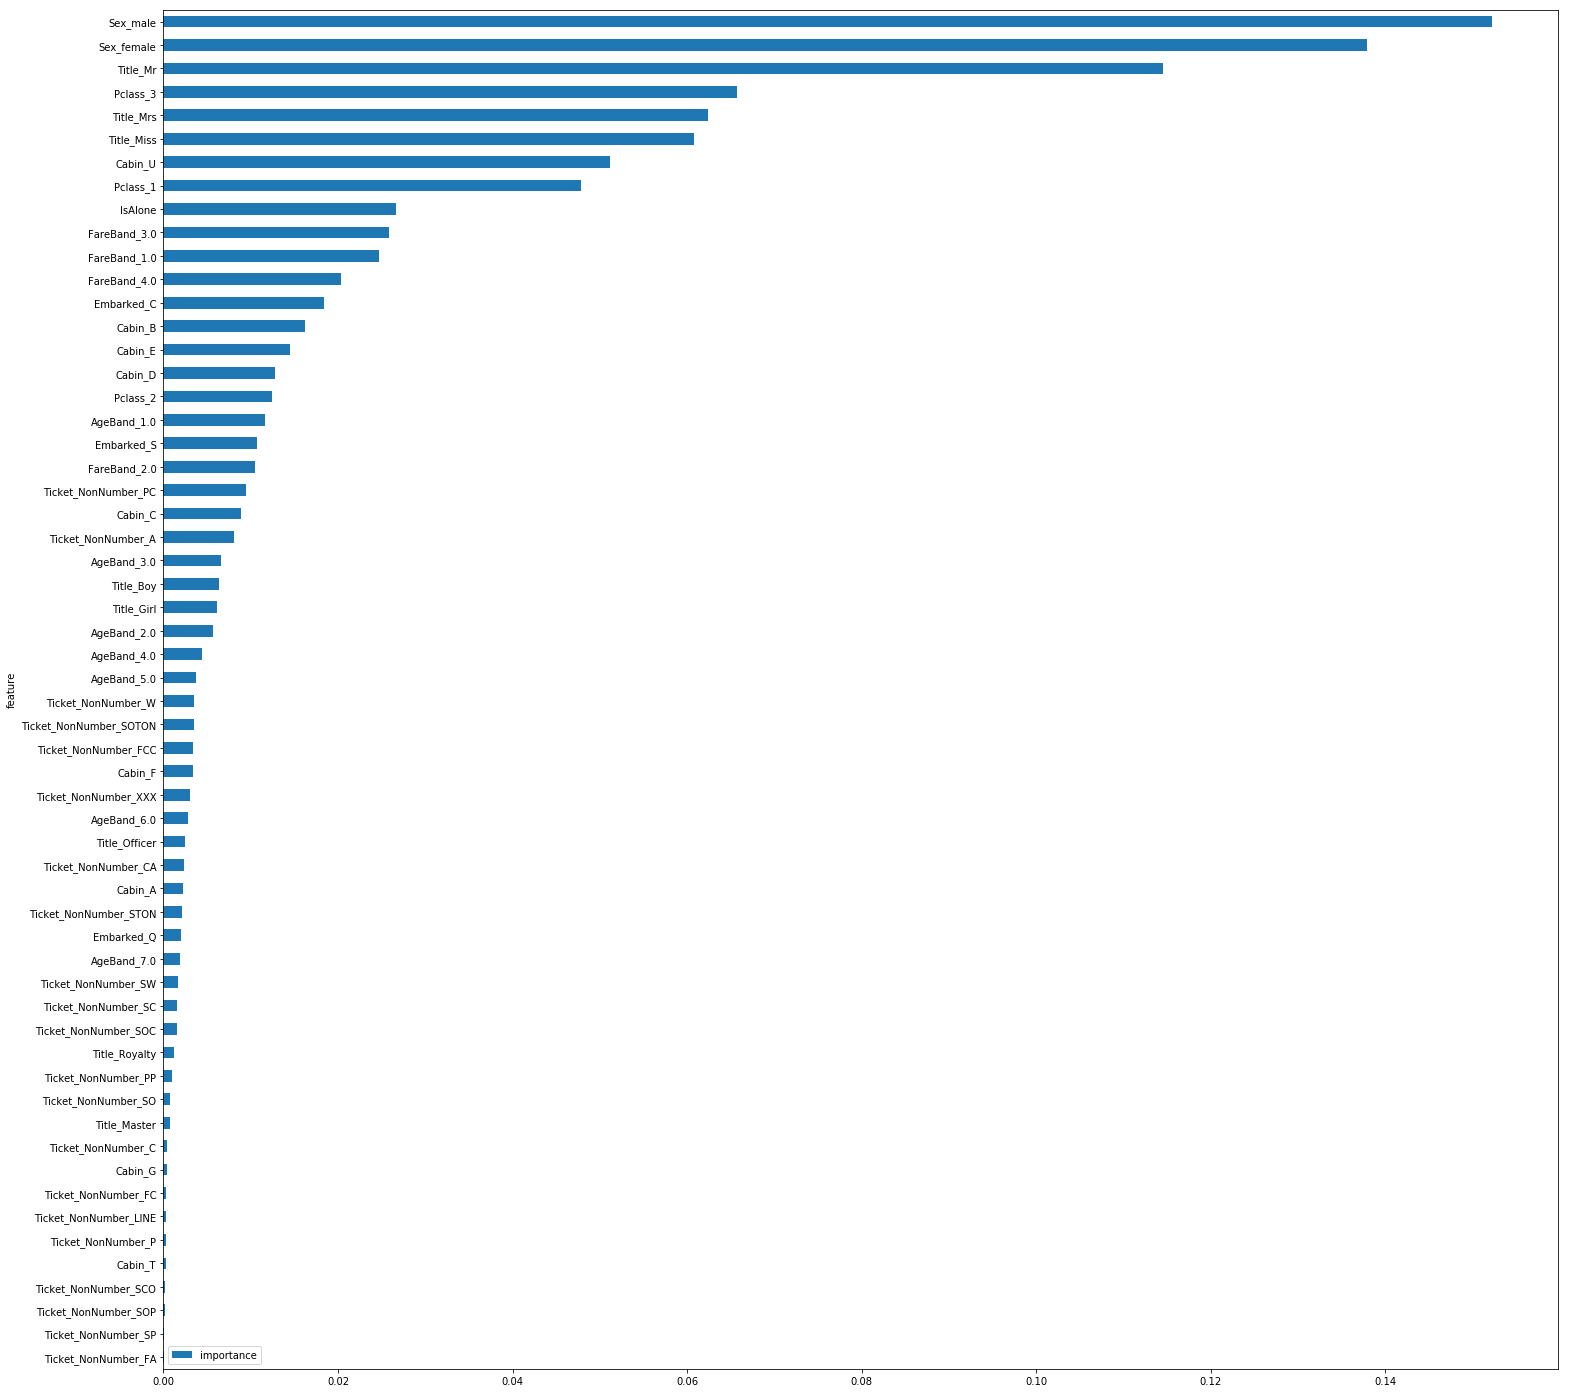

In [14]:
## array([0.81564246, 0.80446927, 0.80898876, 0.79213483, 0.8079096 ])
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=100, max_depth=2, random_state=random_state)

## array([0.79888268, 0.81564246, 0.81460674, 0.80337079, 0.85875706])
clf = RandomForestClassifier(max_depth=4, max_features=3, n_estimators=400)

## array([0.75977654, 0.75977654, 0.7752809 , 0.76966292, 0.82485876])
# clf = VotingClassifier(
#     estimators=[
#         ('lr', LogisticRegression()),
#         ('svc', SVC()),
#         ('tree', DecisionTreeClassifier(max_depth=2, max_features=3)),
#         ('sgd', SGDClassifier()),
#         ('linear_svc', LinearSVC()),
#         ('gaussian', GaussianNB()),
#         ('knn', KNeighborsClassifier(n_neighbors = 2))
#     ],
#     voting='hard',
# )

## array([0.82122905, 0.80446927, 0.79775281, 0.75842697, 0.8079096 ])
# clf = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=1), n_estimators=300,
#     algorithm='SAMME', learning_rate=0.2
# )

# clf = DecisionTreeClassifier()
# cv = cross_val_score(clf, train_df, y, cv=5)
# print(cv)
clf.fit(train_df, y)
# print("*"*40, "running grid search")
# param_test = {'n_estimators': np.linspace(100,500,5, dtype=np.int),
#               'max_depth': [1,2,3,4,6,8],
#               'max_features': ['sqrt', 'auto', 'log2'],
#               'min_samples_split': [2, 3, 10],
#               'min_samples_leaf': [1, 3, 10],
#               'bootstrap': [True, False],
#              }
# gs = GridSearchCV(estimator=clf, param_grid=param_test, cv=5, n_jobs=5, verbose=1)
# gs.fit(train_df, y)
# print("*"*40, "best params", gs.best_params_, gs.best_score_)
# clf.fit(train_df, y)
cv = cross_val_score(clf, train_df, y, cv=5)
print("** before reduced = {}".format(cv))
features = pd.DataFrame()
features['feature'] = train_df.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train_df)
test_reduced = model.transform(test_df)
print("reduced shape", train_reduced.shape, test_reduced.shape)
print("*** retrain after reducing***")
print(np.mean(cross_val_score(clf, train_reduced, y, cv=5)))
clf.fit(train_reduced, y)
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]
for m in models:
    print('Cross-validation of : {0}'.format(m.__class__))
    score = np.mean(cross_val_score(m, X=train_reduced, y=y, scoring='accuracy', cv=5))
    print('CV score = {0}'.format(score))
    print('*'*10)

In [66]:
print("*"*40, "running grid search")
param_test = {'n_estimators': np.linspace(100,500,5, dtype=np.int),
              'max_depth': [1,2,3,4,6,8],
              'max_features': ['sqrt', 'auto', 'log2', 2, 3, 4],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
              'bootstrap': [True, False],
             }
gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_test, cv=5, n_jobs=5, verbose=1)
gs.fit(train_reduced, y)
print("*"*40, "best params for random forest", gs.best_params_, gs.best_score_)

**************************************** running grid search
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   31.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  7.0min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 11.7min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 14.5min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 17.7min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 21.3min
[Parallel(n_jobs=5)]: Done 8440 tasks      | elapsed: 25.0min
[Parallel(n_jobs=5)]: Done 9790 tasks      | elapsed: 28.7min
[Parallel(n_jobs=5)]: Done 11240 tasks      | elapsed: 32.8min
[Parallel(n_jobs=5)]: Done 12790 tasks      | elapsed: 37.2min
[Parallel(

**************************************** best params for random forest {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 8, 'bootstrap': True, 'n_estimators': 300, 'max_features': 4} 0.8249158249158249


In [97]:
best_forest = RandomForestClassifier(**{
    'min_samples_split': 3,                                     
    'min_samples_leaf': 3, 
    'max_depth': 100, 
    'bootstrap': True, 
    'n_estimators': 400, 
    'max_features': 10})
score = np.mean(cross_val_score(best_forest, train_reduced, y, cv=5))
print("** best score for random forest = {}".format(score))
best_forest.fit(train_reduced, y)

** best score for random forest = 0.8182704934805359


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
param_test = {
    'learning_rate': np.linspace(0.1, 0.5, 5),
    'n_estimators': np.linspace(100, 1000, 9, dtype=np.int),
    'max_depth': np.linspace(1, 5, 5, dtype=np.int),
    'min_samples_split': [2,5,10,20],
    'max_features': [2,4,6,8]
}
gs = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_test, cv=5, n_jobs=5, verbose=1)
gs.fit(train_reduced, y)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=5)]: Done 175 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 625 tasks      | elapsed:   25.0s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:   46.6s
[Parallel(n_jobs=5)]: Done 1367 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1817 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 2367 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 3017 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 3767 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 4617 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 5567 tasks      | elapsed: 10.2min
[Parallel(n_jobs=5)]: Done 6617 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 7767 tasks      | elapsed: 15.1min
[Parallel(n_jobs=5)]: Done 9017 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 10367 tasks      | elapsed: 19.9min
[Parallel(n_jobs=5)]: Done 11817 tasks      | elapsed: 22.3min
[Parallel(n_jobs=5)]: Done 13367 tasks      | elapsed: 24.8min
[Parall

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'n_estimators': array([ 100,  212,  325,  437,  550,  662,  775,  887, 1000]), 'max_depth': array([1, 2, 3, 4, 5]), 'min_samples_split': [2, 5, 10, 20], 'max_features': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [ ]:
gs.best_params_, gs.best_score_

In [68]:
ada_boosting = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, algorithm='SAMME', random_state=random_state)
score = np.mean(cross_val_score(ada_boosting, train_reduced, y, cv=5))
print("** score = {}".format(score))

** score = 0.7732880887811738


In [77]:
gradient_boosting = GradientBoostingClassifier(
    learning_rate=0.5,
    n_estimators=437, 
    max_depth= 2,
    min_samples_leaf= 2,
    min_samples_split=2)
score = np.mean(cross_val_score(gradient_boosting, train_reduced, y, cv=5))
gradient_boosting.fit(train_reduced, y)
print("** score = {}".format(score))

** score = 0.8148742440475114


In [124]:
y_pred = best_forest.predict(test_reduced)
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": y_pred
})
test_infos['Survived'] = y_pred
print(test_infos.head())
test_infos.to_csv('titanic_result_feature_engineer_random_forest_inspection.csv')
submission.to_csv('titanic_result_feature_engineer_random_forest.csv', index=False)

   PassengerId                                          Name   Age  SibSp  \
0          892                              Kelly, Mr. James  34.5      0   
1          893              Wilkes, Mrs. James (Ellen Needs)  47.0      1   
2          894                     Myles, Mr. Thomas Francis  62.0      0   
3          895                              Wirz, Mr. Albert  27.0      0   
4          896  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0      1   

   Parch     Fare  FamilySize   Ticket Title Ticket_Number FareBand AgeBand  \
0      0   7.8292           1   330911    Mr        330911      0.0     1.0   
1      0   7.0000           2   363272   Mrs        363272      0.0     2.0   
2      0   9.6875           1   240276    Mr        240276      1.0     2.0   
3      0   8.6625           1   315154    Mr        315154      1.0     1.0   
4      1  12.2875           3  3101298   Mrs       3101298      1.0     1.0   

  Pclass  IsAlone  Survived  
0      3        1         0  
1 

/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
submission_inspection.head(100)

,AgeBand_0.0,AgeBand_1.0,AgeBand_2.0,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,...,Ticket_NonNumber_W,Ticket_NonNumber_XXX,Title_Boy,Title_Girl,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
! kaggle competitions submit titanic -f titanic_result_feature_engineer_random_forest.csv -m "feature engineer (fix ticket) + random forest"

Successfully submitted to Titanic: Machine Learning from Disaster

In [74]:
clf1 = KNeighborsClassifier(n_neighbors=2)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[best_forest, ada_boosting, gradient_boosting, clf1, clf3], 
                          meta_classifier=lr)
np.mean(cross_val_score(sclf, train_reduced, y, cv=5))
sclf.fit(train_reduced, y)

StackingClassifier(average_probas=False,
          classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_...c_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform'), GaussianNB(priors=None)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [60]:
train_reduced.shape[1]

13

In [68]:
nn = Sequential([
    Dense(64, input_shape=(train_reduced.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto')
callback_list = [earlystop]
sgd = optimizers.SGD(lr=1e-6, decay=1e-8, momentum=0.9, nesterov=True)
# For a binary classification problem
nn.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
nn.fit(train_reduced, y, epochs=1000, batch_size=32, validation_split=0.2, shuffle=True, callbacks=callback_list)

Train on 712 samples, validate on 179 samples
Epoch 1/1000
712/712 [==============================] - 1s 971us/step - loss: 0.6998 - acc: 0.5084 - val_loss: 0.6752 - val_acc: 0.7095
Epoch 2/1000
712/712 [==============================] - 0s 146us/step - loss: 0.6893 - acc: 0.5478 - val_loss: 0.6751 - val_acc: 0.7095
Epoch 3/1000
712/712 [==============================] - 0s 123us/step - loss: 0.6964 - acc: 0.5028 - val_loss: 0.6751 - val_acc: 0.7095
Epoch 4/1000
712/712 [==============================] - 0s 122us/step - loss: 0.6903 - acc: 0.5295 - val_loss: 0.6751 - val_acc: 0.7095
Epoch 5/1000
712/712 [==============================] - 0s 125us/step - loss: 0.6889 - acc: 0.5520 - val_loss: 0.6751 - val_acc: 0.7095
Epoch 6/1000
712/712 [==============================] - 0s 112us/step - loss: 0.6967 - acc: 0.5098 - val_loss: 0.6751 - val_acc: 0.7095
Epoch 7/1000
712/712 [==============================] - 0s 126us/step - loss: 0.6919 - acc: 0.5281 - val_loss: 0.6751 - val_acc: 0.7095
Ep

Epoch 120/1000
712/712 [==============================] - 0s 135us/step - loss: 0.6967 - acc: 0.5154 - val_loss: 0.6730 - val_acc: 0.6927
Epoch 121/1000
712/712 [==============================] - 0s 129us/step - loss: 0.6897 - acc: 0.5351 - val_loss: 0.6730 - val_acc: 0.6927
Epoch 122/1000
712/712 [==============================] - 0s 132us/step - loss: 0.6908 - acc: 0.5407 - val_loss: 0.6730 - val_acc: 0.6927
Epoch 123/1000
712/712 [==============================] - 0s 161us/step - loss: 0.6868 - acc: 0.5548 - val_loss: 0.6730 - val_acc: 0.6927
Epoch 124/1000
712/712 [==============================] - 0s 138us/step - loss: 0.6871 - acc: 0.5323 - val_loss: 0.6730 - val_acc: 0.6927
Epoch 125/1000
712/712 [==============================] - 0s 139us/step - loss: 0.6915 - acc: 0.5421 - val_loss: 0.6729 - val_acc: 0.6927
Epoch 126/1000
712/712 [==============================] - 0s 139us/step - loss: 0.6932 - acc: 0.5379 - val_loss: 0.6729 - val_acc: 0.6927
Epoch 127/1000
712/712 [==========

712/712 [==============================] - 0s 138us/step - loss: 0.6839 - acc: 0.5435 - val_loss: 0.6710 - val_acc: 0.6983
Epoch 239/1000
712/712 [==============================] - 0s 144us/step - loss: 0.6899 - acc: 0.5421 - val_loss: 0.6710 - val_acc: 0.6983
Epoch 240/1000
712/712 [==============================] - 0s 137us/step - loss: 0.6904 - acc: 0.5604 - val_loss: 0.6710 - val_acc: 0.6983
Epoch 241/1000
712/712 [==============================] - 0s 137us/step - loss: 0.6839 - acc: 0.5744 - val_loss: 0.6710 - val_acc: 0.6983
Epoch 242/1000
712/712 [==============================] - 0s 134us/step - loss: 0.6950 - acc: 0.5183 - val_loss: 0.6709 - val_acc: 0.6983
Epoch 243/1000
712/712 [==============================] - 0s 130us/step - loss: 0.6897 - acc: 0.5309 - val_loss: 0.6709 - val_acc: 0.6983
Epoch 244/1000
712/712 [==============================] - 0s 134us/step - loss: 0.6763 - acc: 0.5702 - val_loss: 0.6709 - val_acc: 0.6983
Epoch 245/1000
712/712 [=========================

712/712 [==============================] - 0s 109us/step - loss: 0.6889 - acc: 0.5478 - val_loss: 0.6690 - val_acc: 0.6704
Epoch 357/1000
712/712 [==============================] - 0s 107us/step - loss: 0.6941 - acc: 0.5112 - val_loss: 0.6690 - val_acc: 0.6704
Epoch 358/1000
712/712 [==============================] - 0s 114us/step - loss: 0.6838 - acc: 0.5646 - val_loss: 0.6690 - val_acc: 0.6704
Epoch 359/1000
712/712 [==============================] - 0s 122us/step - loss: 0.6912 - acc: 0.5112 - val_loss: 0.6690 - val_acc: 0.6704
Epoch 360/1000
712/712 [==============================] - 0s 110us/step - loss: 0.6926 - acc: 0.5351 - val_loss: 0.6689 - val_acc: 0.6704
Epoch 361/1000
712/712 [==============================] - 0s 110us/step - loss: 0.6870 - acc: 0.5463 - val_loss: 0.6689 - val_acc: 0.6704
Epoch 362/1000
712/712 [==============================] - 0s 116us/step - loss: 0.6884 - acc: 0.5295 - val_loss: 0.6689 - val_acc: 0.6704
Epoch 363/1000
712/712 [=========================

712/712 [==============================] - 0s 128us/step - loss: 0.6874 - acc: 0.5463 - val_loss: 0.6671 - val_acc: 0.6592
Epoch 475/1000
712/712 [==============================] - 0s 110us/step - loss: 0.6838 - acc: 0.5534 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 476/1000
712/712 [==============================] - 0s 121us/step - loss: 0.6828 - acc: 0.5478 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 477/1000
712/712 [==============================] - 0s 124us/step - loss: 0.6805 - acc: 0.5646 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 478/1000
712/712 [==============================] - 0s 134us/step - loss: 0.6914 - acc: 0.5225 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 479/1000
712/712 [==============================] - 0s 116us/step - loss: 0.6775 - acc: 0.5955 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 480/1000
712/712 [==============================] - 0s 127us/step - loss: 0.6898 - acc: 0.5435 - val_loss: 0.6670 - val_acc: 0.6592
Epoch 481/1000
712/712 [=========================

712/712 [==============================] - 0s 146us/step - loss: 0.6797 - acc: 0.5758 - val_loss: 0.6652 - val_acc: 0.6592
Epoch 593/1000
712/712 [==============================] - 0s 154us/step - loss: 0.6801 - acc: 0.5618 - val_loss: 0.6652 - val_acc: 0.6592
Epoch 594/1000
712/712 [==============================] - 0s 135us/step - loss: 0.6843 - acc: 0.5562 - val_loss: 0.6651 - val_acc: 0.6592
Epoch 595/1000
712/712 [==============================] - 0s 128us/step - loss: 0.6913 - acc: 0.5253 - val_loss: 0.6651 - val_acc: 0.6592
Epoch 596/1000
712/712 [==============================] - 0s 129us/step - loss: 0.6854 - acc: 0.5407 - val_loss: 0.6651 - val_acc: 0.6592
Epoch 597/1000
712/712 [==============================] - 0s 125us/step - loss: 0.6757 - acc: 0.5548 - val_loss: 0.6651 - val_acc: 0.6592
Epoch 598/1000
712/712 [==============================] - 0s 138us/step - loss: 0.6788 - acc: 0.5520 - val_loss: 0.6651 - val_acc: 0.6592
Epoch 599/1000
712/712 [=========================

712/712 [==============================] - 0s 109us/step - loss: 0.6789 - acc: 0.5618 - val_loss: 0.6634 - val_acc: 0.6536
Epoch 711/1000
712/712 [==============================] - 0s 117us/step - loss: 0.6825 - acc: 0.5295 - val_loss: 0.6634 - val_acc: 0.6536
Epoch 712/1000
712/712 [==============================] - 0s 121us/step - loss: 0.6792 - acc: 0.5520 - val_loss: 0.6633 - val_acc: 0.6536
Epoch 713/1000
712/712 [==============================] - 0s 111us/step - loss: 0.6854 - acc: 0.5744 - val_loss: 0.6633 - val_acc: 0.6536
Epoch 714/1000
712/712 [==============================] - 0s 104us/step - loss: 0.6877 - acc: 0.5562 - val_loss: 0.6633 - val_acc: 0.6536
Epoch 715/1000
712/712 [==============================] - 0s 100us/step - loss: 0.6827 - acc: 0.5534 - val_loss: 0.6633 - val_acc: 0.6536
Epoch 716/1000
712/712 [==============================] - 0s 106us/step - loss: 0.6863 - acc: 0.5323 - val_loss: 0.6633 - val_acc: 0.6536
Epoch 717/1000
712/712 [=========================

712/712 [==============================] - 0s 146us/step - loss: 0.6783 - acc: 0.5772 - val_loss: 0.6616 - val_acc: 0.6536
Epoch 829/1000
712/712 [==============================] - 0s 132us/step - loss: 0.6827 - acc: 0.5562 - val_loss: 0.6616 - val_acc: 0.6536
Epoch 830/1000
712/712 [==============================] - 0s 150us/step - loss: 0.6788 - acc: 0.5632 - val_loss: 0.6616 - val_acc: 0.6536
Epoch 831/1000
712/712 [==============================] - 0s 139us/step - loss: 0.6819 - acc: 0.5576 - val_loss: 0.6615 - val_acc: 0.6536
Epoch 832/1000
712/712 [==============================] - 0s 110us/step - loss: 0.6760 - acc: 0.5829 - val_loss: 0.6615 - val_acc: 0.6536
Epoch 833/1000
712/712 [==============================] - 0s 131us/step - loss: 0.6785 - acc: 0.5801 - val_loss: 0.6615 - val_acc: 0.6536
Epoch 834/1000
712/712 [==============================] - 0s 126us/step - loss: 0.6775 - acc: 0.5688 - val_loss: 0.6615 - val_acc: 0.6536
Epoch 835/1000
712/712 [=========================

KeyboardInterrupt: 